In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score, f1_score
%matplotlib inline
sns.set_style()

In [2]:
df = pd.read_json('/Users/butler/Documents/hp/ultimate_challenge/ultimate_data_challenge.json')

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
df.shape

(50000, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [7]:
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [8]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [9]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [10]:
df.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [11]:
df['city'].nunique()

3

In [12]:
df['months_retained'] = (df['last_trip_date'] + np.timedelta64(30, 'D') - df['signup_date']) // np.timedelta64(1, 'M')

In [13]:
df.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [14]:
df['months_retained'].value_counts()

6    11194
5    10847
1    10725
4     6281
3     4488
2     4163
0     2302
Name: months_retained, dtype: int64

In [15]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [16]:
df['6months'] = df['months_retained'] == 6

In [17]:
df['6months'] = df['6months'].astype(int)

In [18]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,months_retained,6months
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,5,0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,4,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,1,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,6,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,2,0


In [19]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [20]:
df.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
surge_pct                 float64
ultimate_black_user         int64
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
months_retained             int64
6months                     int64
dtype: object

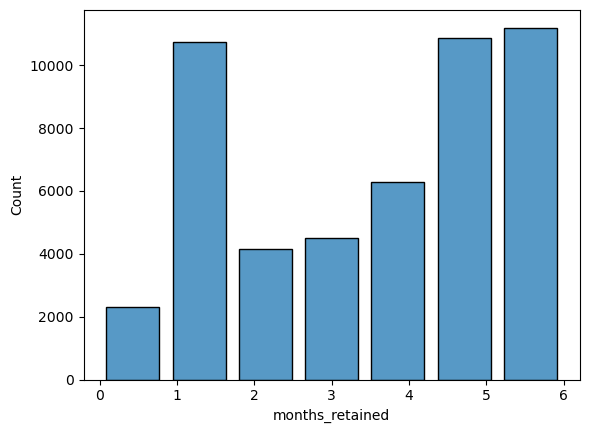

In [21]:
fig = sns.histplot(data=df, x='months_retained', bins=7,shrink=.8)



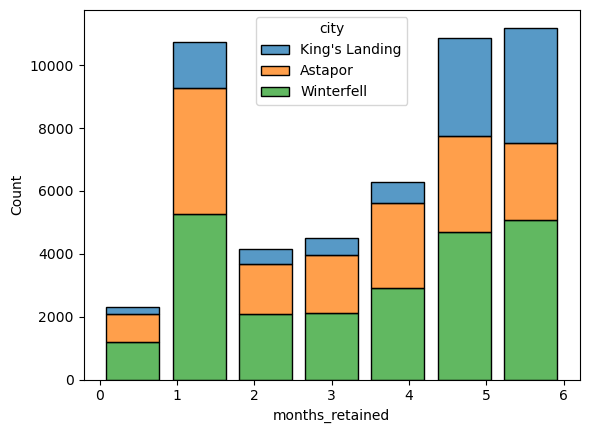

In [22]:
_ = sns.histplot(data=df, x='months_retained', hue='city', multiple='stack', bins=7, shrink=.8)

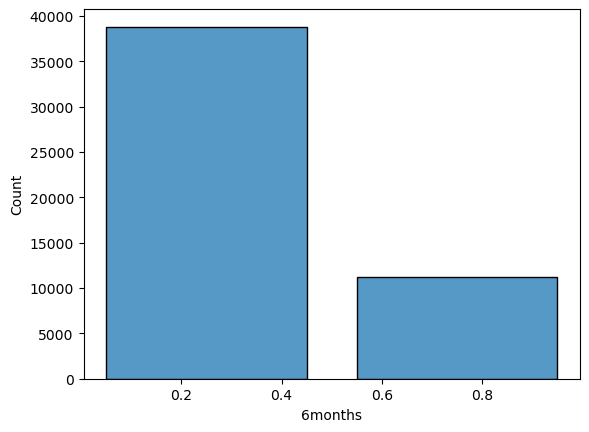

In [23]:
_ = sns.histplot(data=df, x='6months', bins=2, shrink=.8)


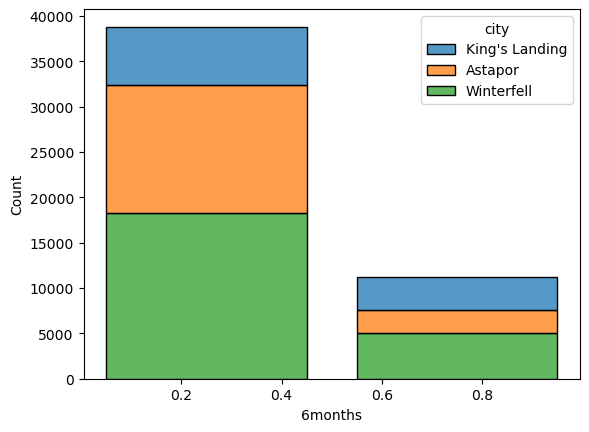

In [24]:
_ = sns.histplot(data=df, x='6months', bins=2, multiple='stack', hue='city', shrink=.8)

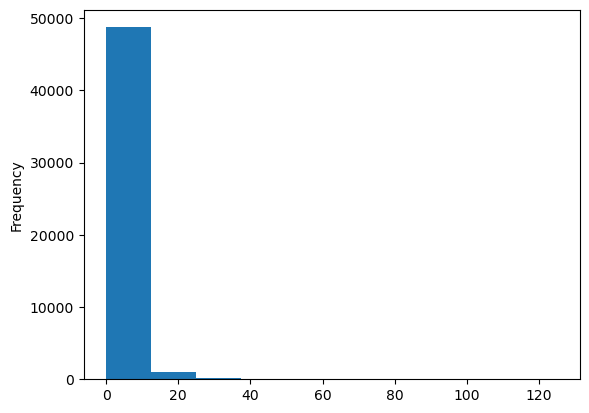

In [25]:
_ = df['trips_in_first_30_days'].plot.hist()

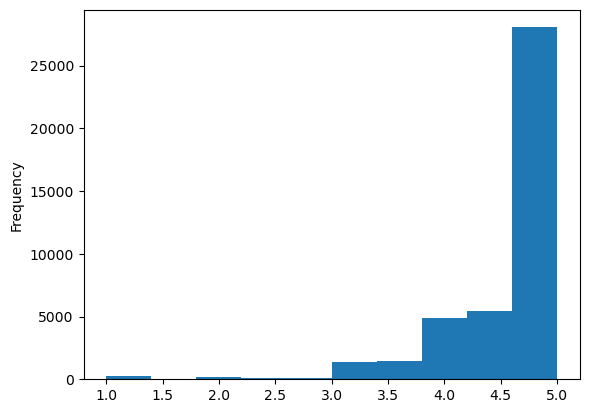

In [26]:
_= df['avg_rating_of_driver'].plot.hist()

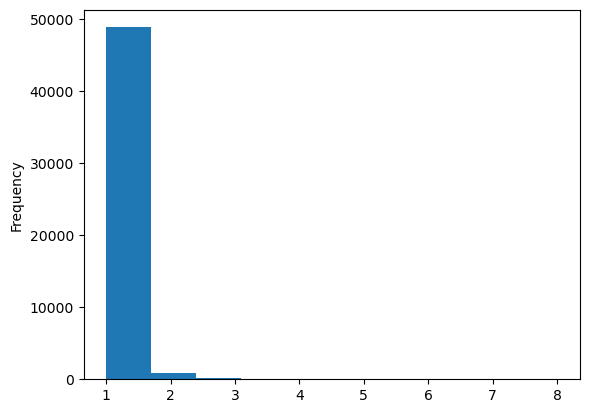

In [27]:
_= df['avg_surge'].plot.hist()

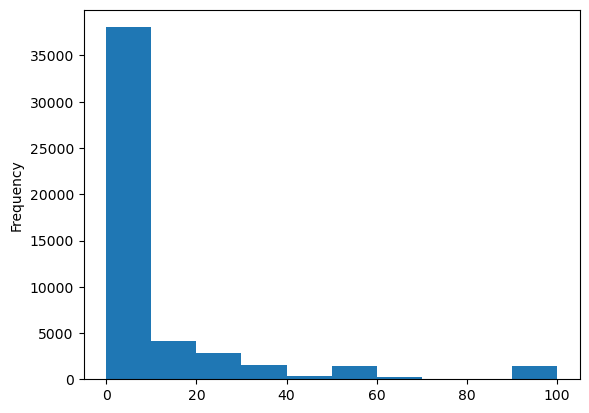

In [28]:
_= df['surge_pct'].plot.hist()

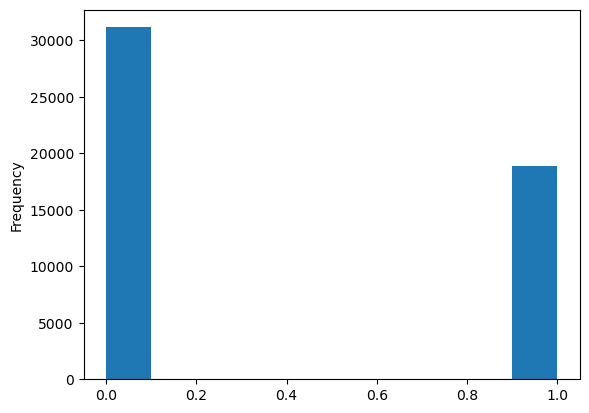

In [29]:
_= df['ultimate_black_user'].plot.hist()

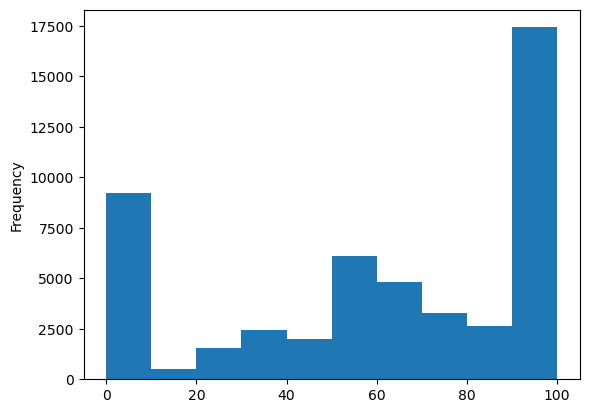

In [30]:
_= df['weekday_pct'].plot.hist()

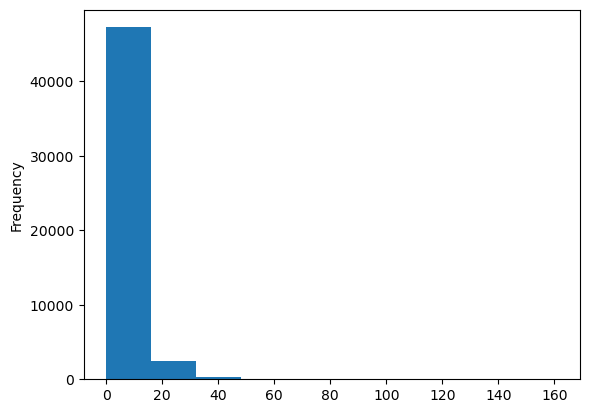

In [31]:
_= df['avg_dist'].plot.hist()

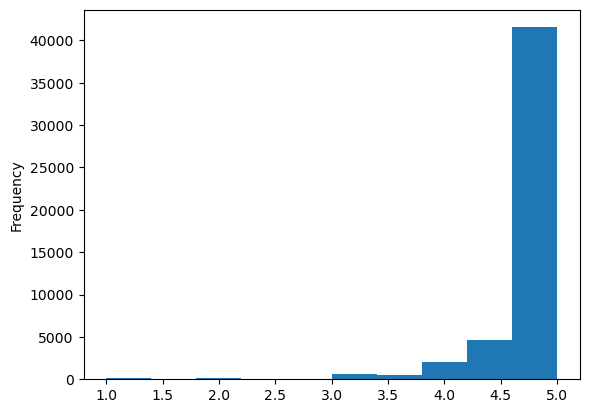

In [32]:
_= df['avg_rating_by_driver'].plot.hist()

In [33]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,months_retained,6months
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,5,0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,4,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,1,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,6,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,2,0


In [34]:
df.tail()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,months_retained,6months
49995,King's Landing,0,5.0,1.0,iPhone,0.0,0,100.0,5.63,4.2,5,0
49996,Astapor,1,NaN,1.0,iPhone,0.0,0,0.0,0.00,4.0,1,0
49997,Winterfell,0,5.0,1.0,Android,0.0,1,100.0,3.86,5.0,4,0
49998,Astapor,2,3.0,1.0,iPhone,0.0,0,100.0,4.58,3.5,1,0
49999,Astapor,0,NaN,1.0,Android,0.0,0,0.0,3.49,5.0,4,0


/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_9194/1127840755.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df.corr(), vmin=-.5, vmax=1, annot=True, fmt=".2f", linewidth=.5, cmap="crest")


<Axes: >

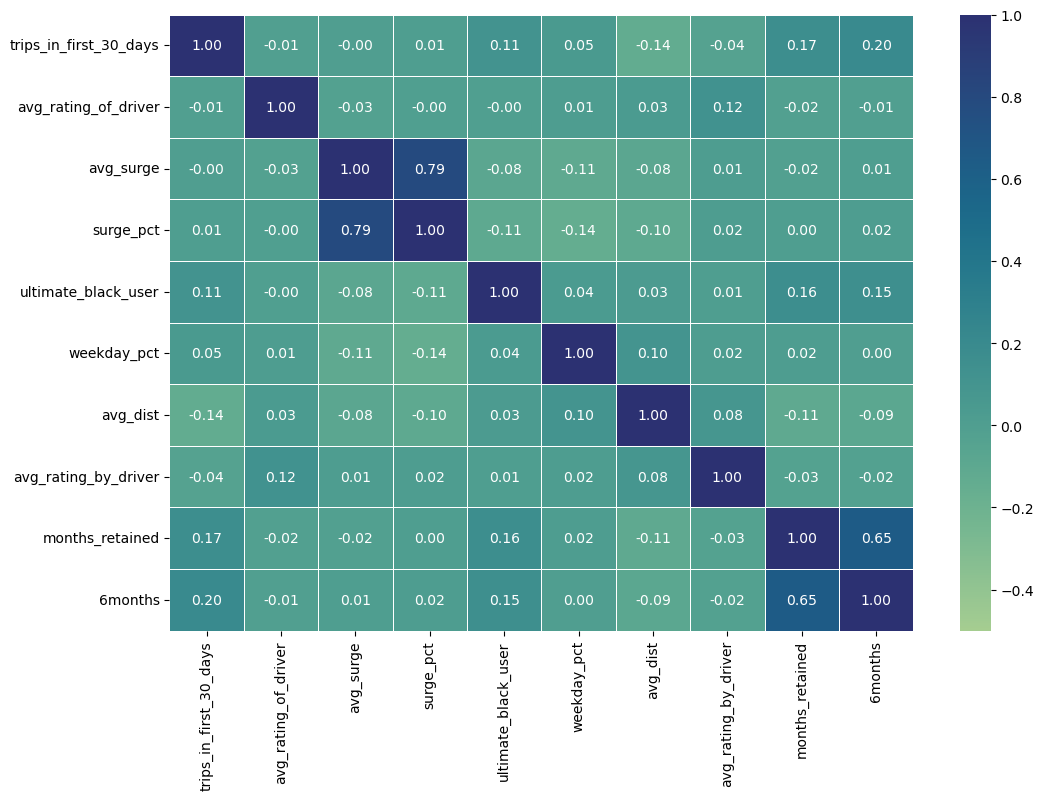

In [35]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data=df.corr(), vmin=-.5, vmax=1, annot=True, fmt=".2f", linewidth=.5, cmap="crest")

In [36]:
df.drop('months_retained', axis=1, inplace=True)

In [37]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [38]:
df.phone = df.phone.fillna('iPhone')

In [39]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,6months
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0


In [40]:
X = df.drop('6months', axis=1)
y = df['6months']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
X_train = X_train.fillna()

In [42]:
lgbm = LGBMClassifier()

pipe.fit(X_train, y_train)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: "King's Landing"

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
y_pred[:20]

In [ ]:
y_test[:20]

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

_ = ConfusionMatrixDisplay(cm).plot()

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

In [ ]:
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'f1: {f1_score(y_test, y_pred)}')